In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#import graphviz
import pyarrow
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

sns.set_style("white")
plt.rcParams['figure.dpi'] = 300

In [43]:
eng_stats_df = pd.read_feather("Award_Batting_HOF_FE.feather")

In [44]:
# X = eng_stats_df[['Batting_df_G_avg', 'Batting_df_G_total', 'Batting_df_AB_avg', 'Batting_df_AB_total', 'Batting_df_R_avg', 'Batting_df_R_total', 'Batting_df_H_avg', 'Batting_df_H_total', 'Batting_df_2B_avg', 'Batting_df_2B_total', 'Batting_df_3B_avg', 'Batting_df_3B_total', 'Batting_df_HR_avg', 'Batting_df_HR_total', 'Batting_df_RBI_avg', 'Batting_df_RBI_total', 'Batting_df_SB_avg', 'Batting_df_SB_total', 'Batting_df_CS_avg', 'Batting_df_CS_total', 'Batting_df_BB_avg', 'Batting_df_BB_total', 'Batting_df_SO_avg', 'Batting_df_SO_total', 'Batting_df_IBB_avg', 'Batting_df_IBB_total', 'Batting_df_HBP_avg', 'Batting_df_HBP_total', 'Batting_df_SH_avg', 'Batting_df_SH_total', 'Batting_df_SF_avg', 'Batting_df_SF_total', 'Batting_df_GIDP_avg', 'Batting_df_GIDP_total', 'BattingPost_df_G_avg', 'BattingPost_df_G_total', 'BattingPost_df_AB_avg', 'BattingPost_df_AB_total', 'BattingPost_df_R_avg', 'BattingPost_df_R_total', 'BattingPost_df_H_avg', 'BattingPost_df_H_total', 'BattingPost_df_2B_avg', 'BattingPost_df_2B_total', 'BattingPost_df_3B_avg', 'BattingPost_df_3B_total', 'BattingPost_df_HR_avg', 'BattingPost_df_HR_total', 'BattingPost_df_RBI_avg', 'BattingPost_df_RBI_total', 'BattingPost_df_SB_avg', 'BattingPost_df_SB_total', 'BattingPost_df_CS_avg', 'BattingPost_df_CS_total', 'BattingPost_df_BB_avg', 'BattingPost_df_BB_total', 'BattingPost_df_SO_avg', 'BattingPost_df_SO_total', 'BattingPost_df_IBB_avg', 'BattingPost_df_IBB_total', 'BattingPost_df_HBP_avg', 'BattingPost_df_HBP_total', 'BattingPost_df_SH_avg', 'BattingPost_df_SH_total', 'BattingPost_df_SF_avg', 'BattingPost_df_SF_total', 'BattingPost_df_GIDP_avg', 'BattingPost_df_GIDP_total']]

X = eng_stats_df[[
    'years_played', 'total_games', 'total_at_bats', 'total_runs', 'total_hits',
    'total_walks', 'total_doubles', 'total_triples', 'total_home_runs',
    'total_RBI', 'total_SB', 'total_CS', 'total_BB', 'total_SO', 'total_IBB',
    'total_HBP', 'total_SH', 'total_SF', 'total_GIDP', 'max_HR', 'max_hits',
    'max_SB', 'total_singles', 'batting_avg', 'OBP', 'SLG', 'OPS'
]].fillna(0)  # Replace NaNs with 0

y = eng_stats_df['HOF_status'].fillna(0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfr_model_1 = RandomForestRegressor()
rfr_model_1.fit(X_train_scaled, y_train)

y_pred = rfr_model_1.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

Mean Squared Error: 0.004577285298508677
R-squared: 0.7084542183176044
Root Mean Squared Error (RMSE): 0.0676556375959068
Mean Absolute Percentage Error (MAPE): 2687270500825330.50%


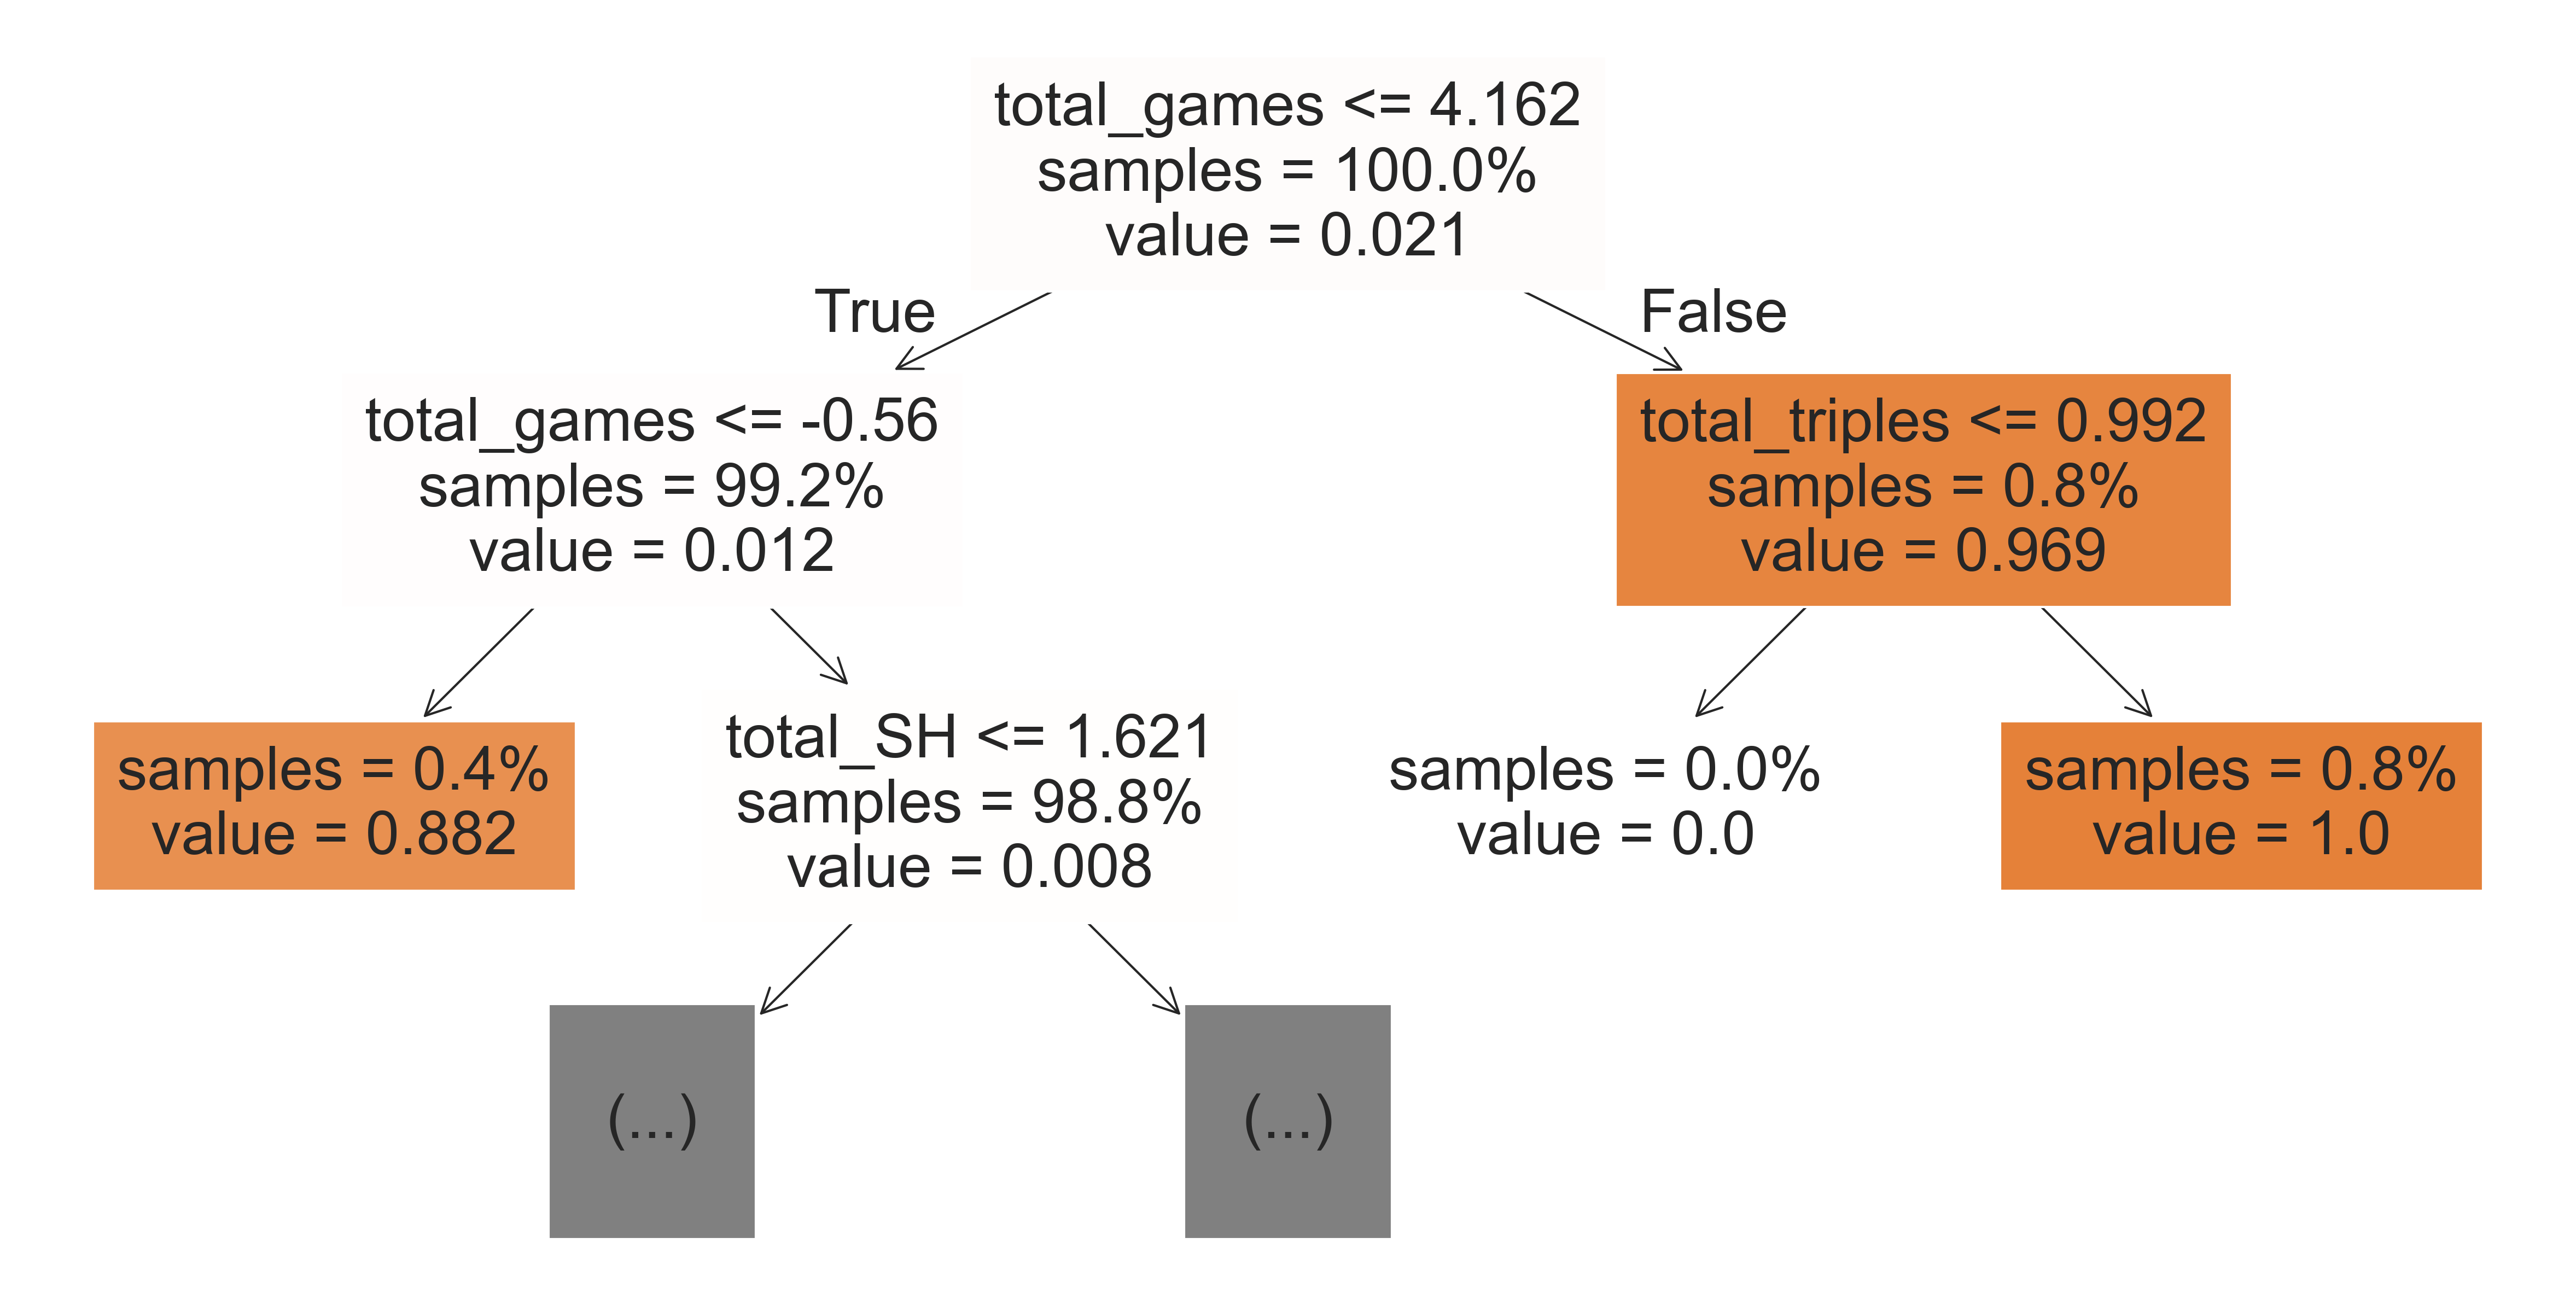

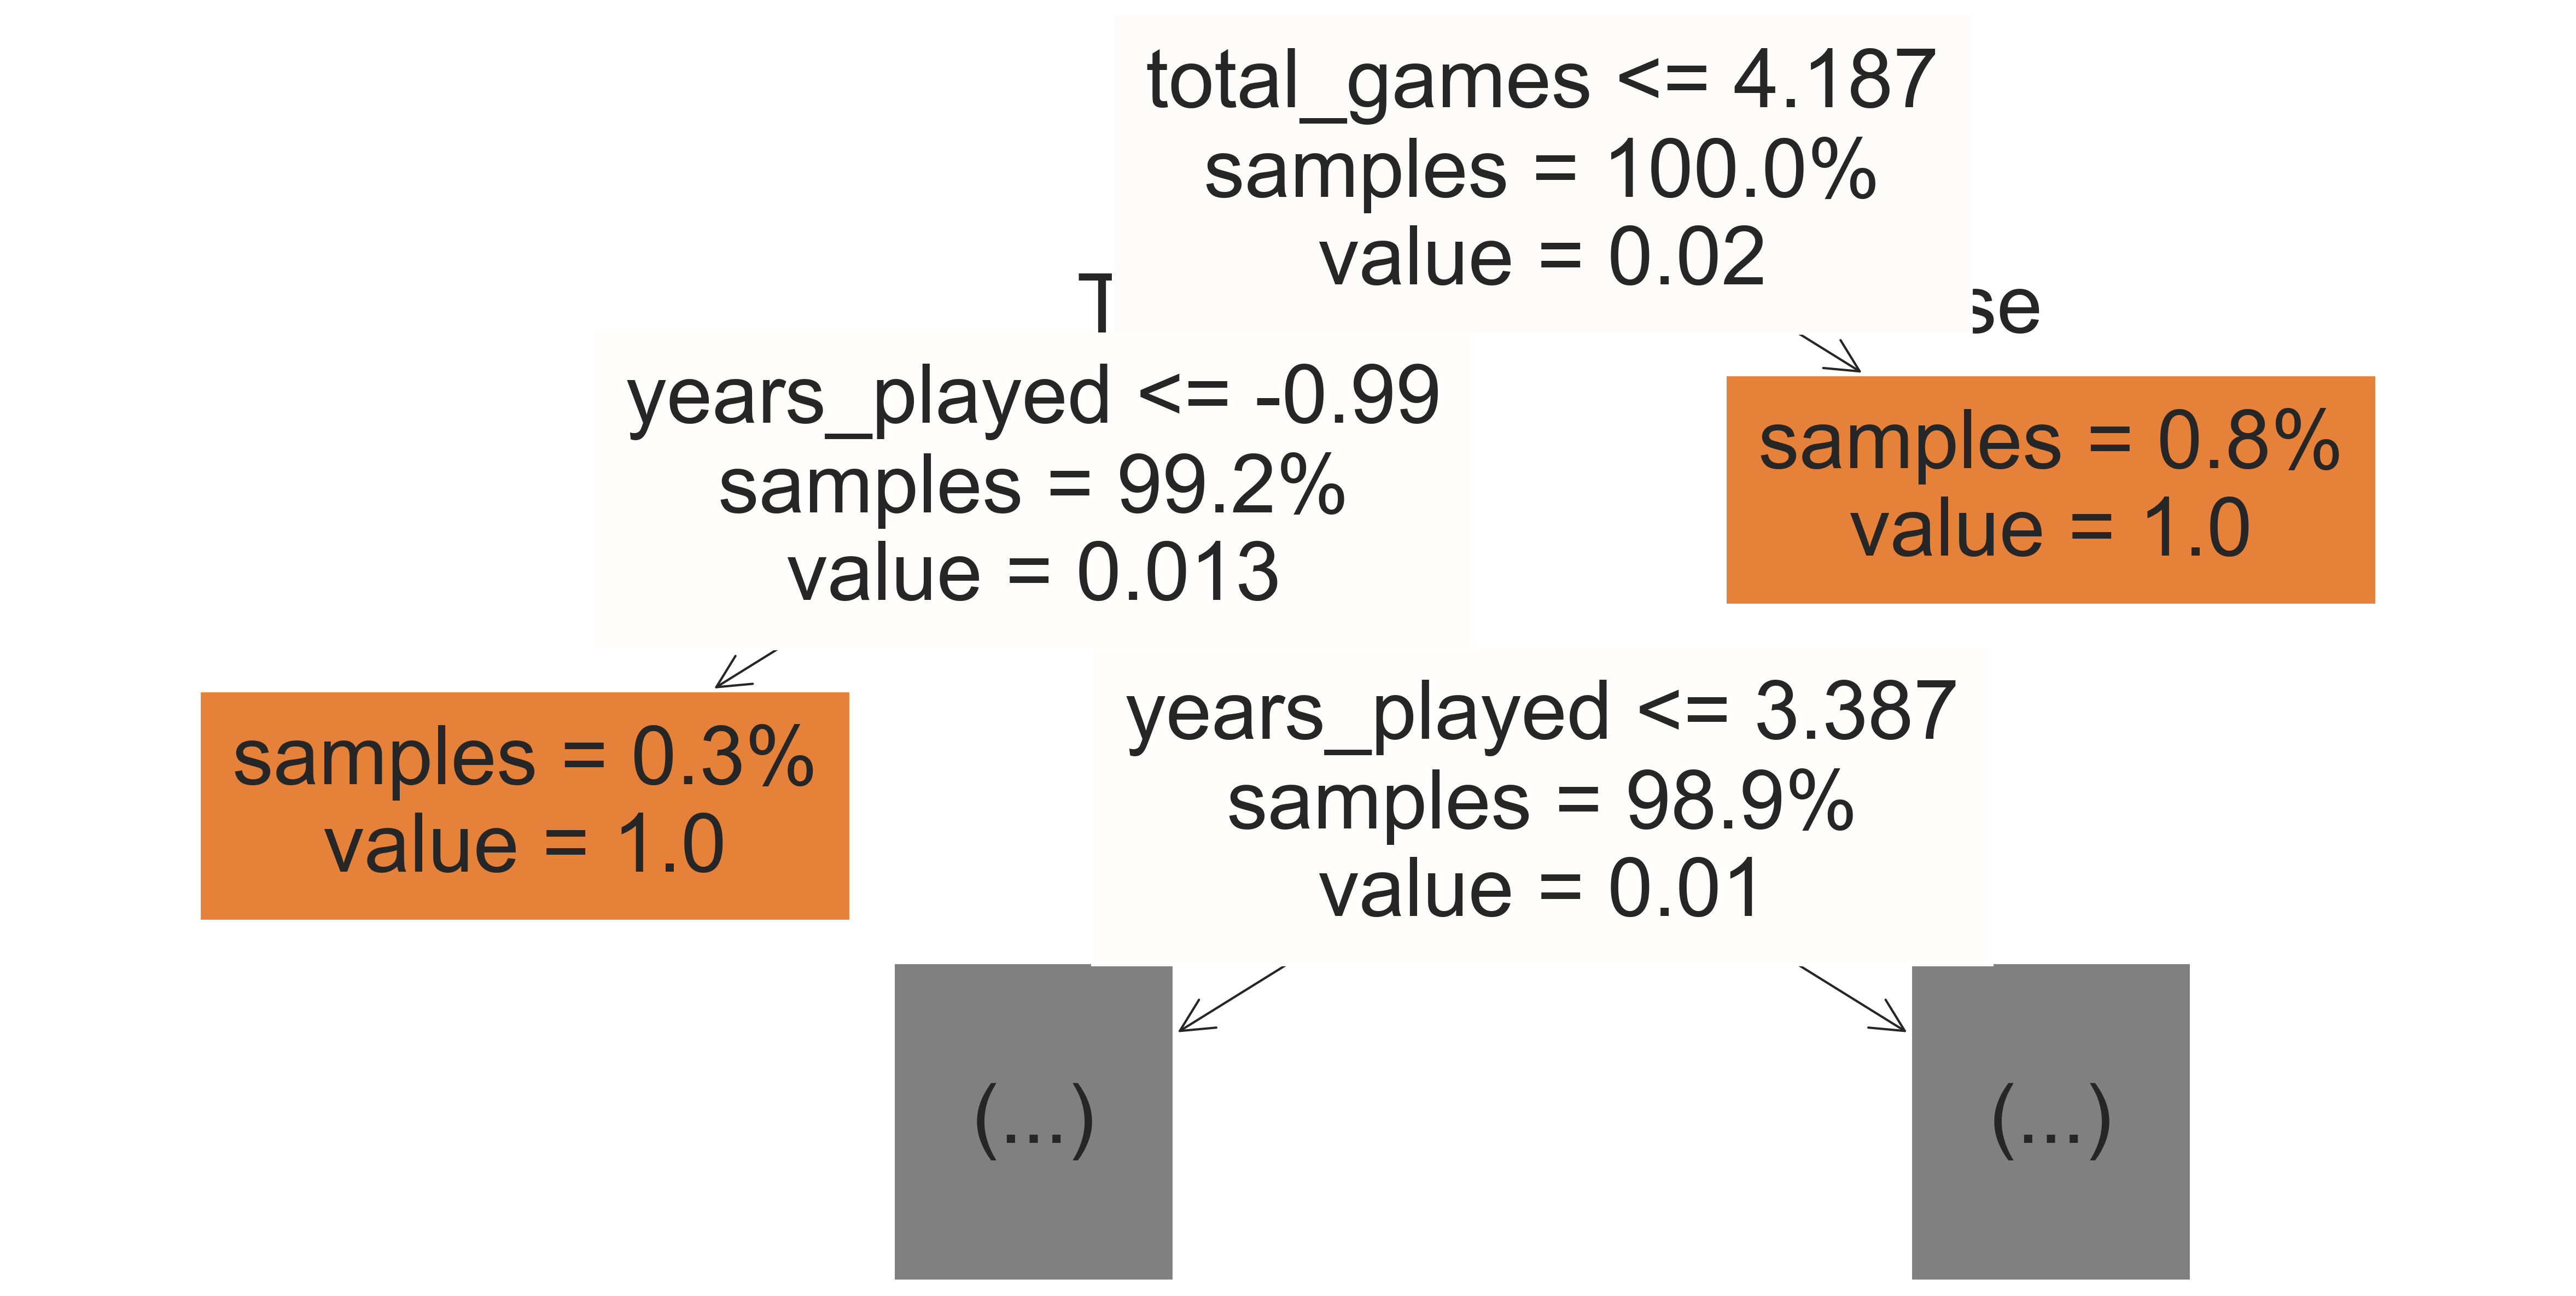

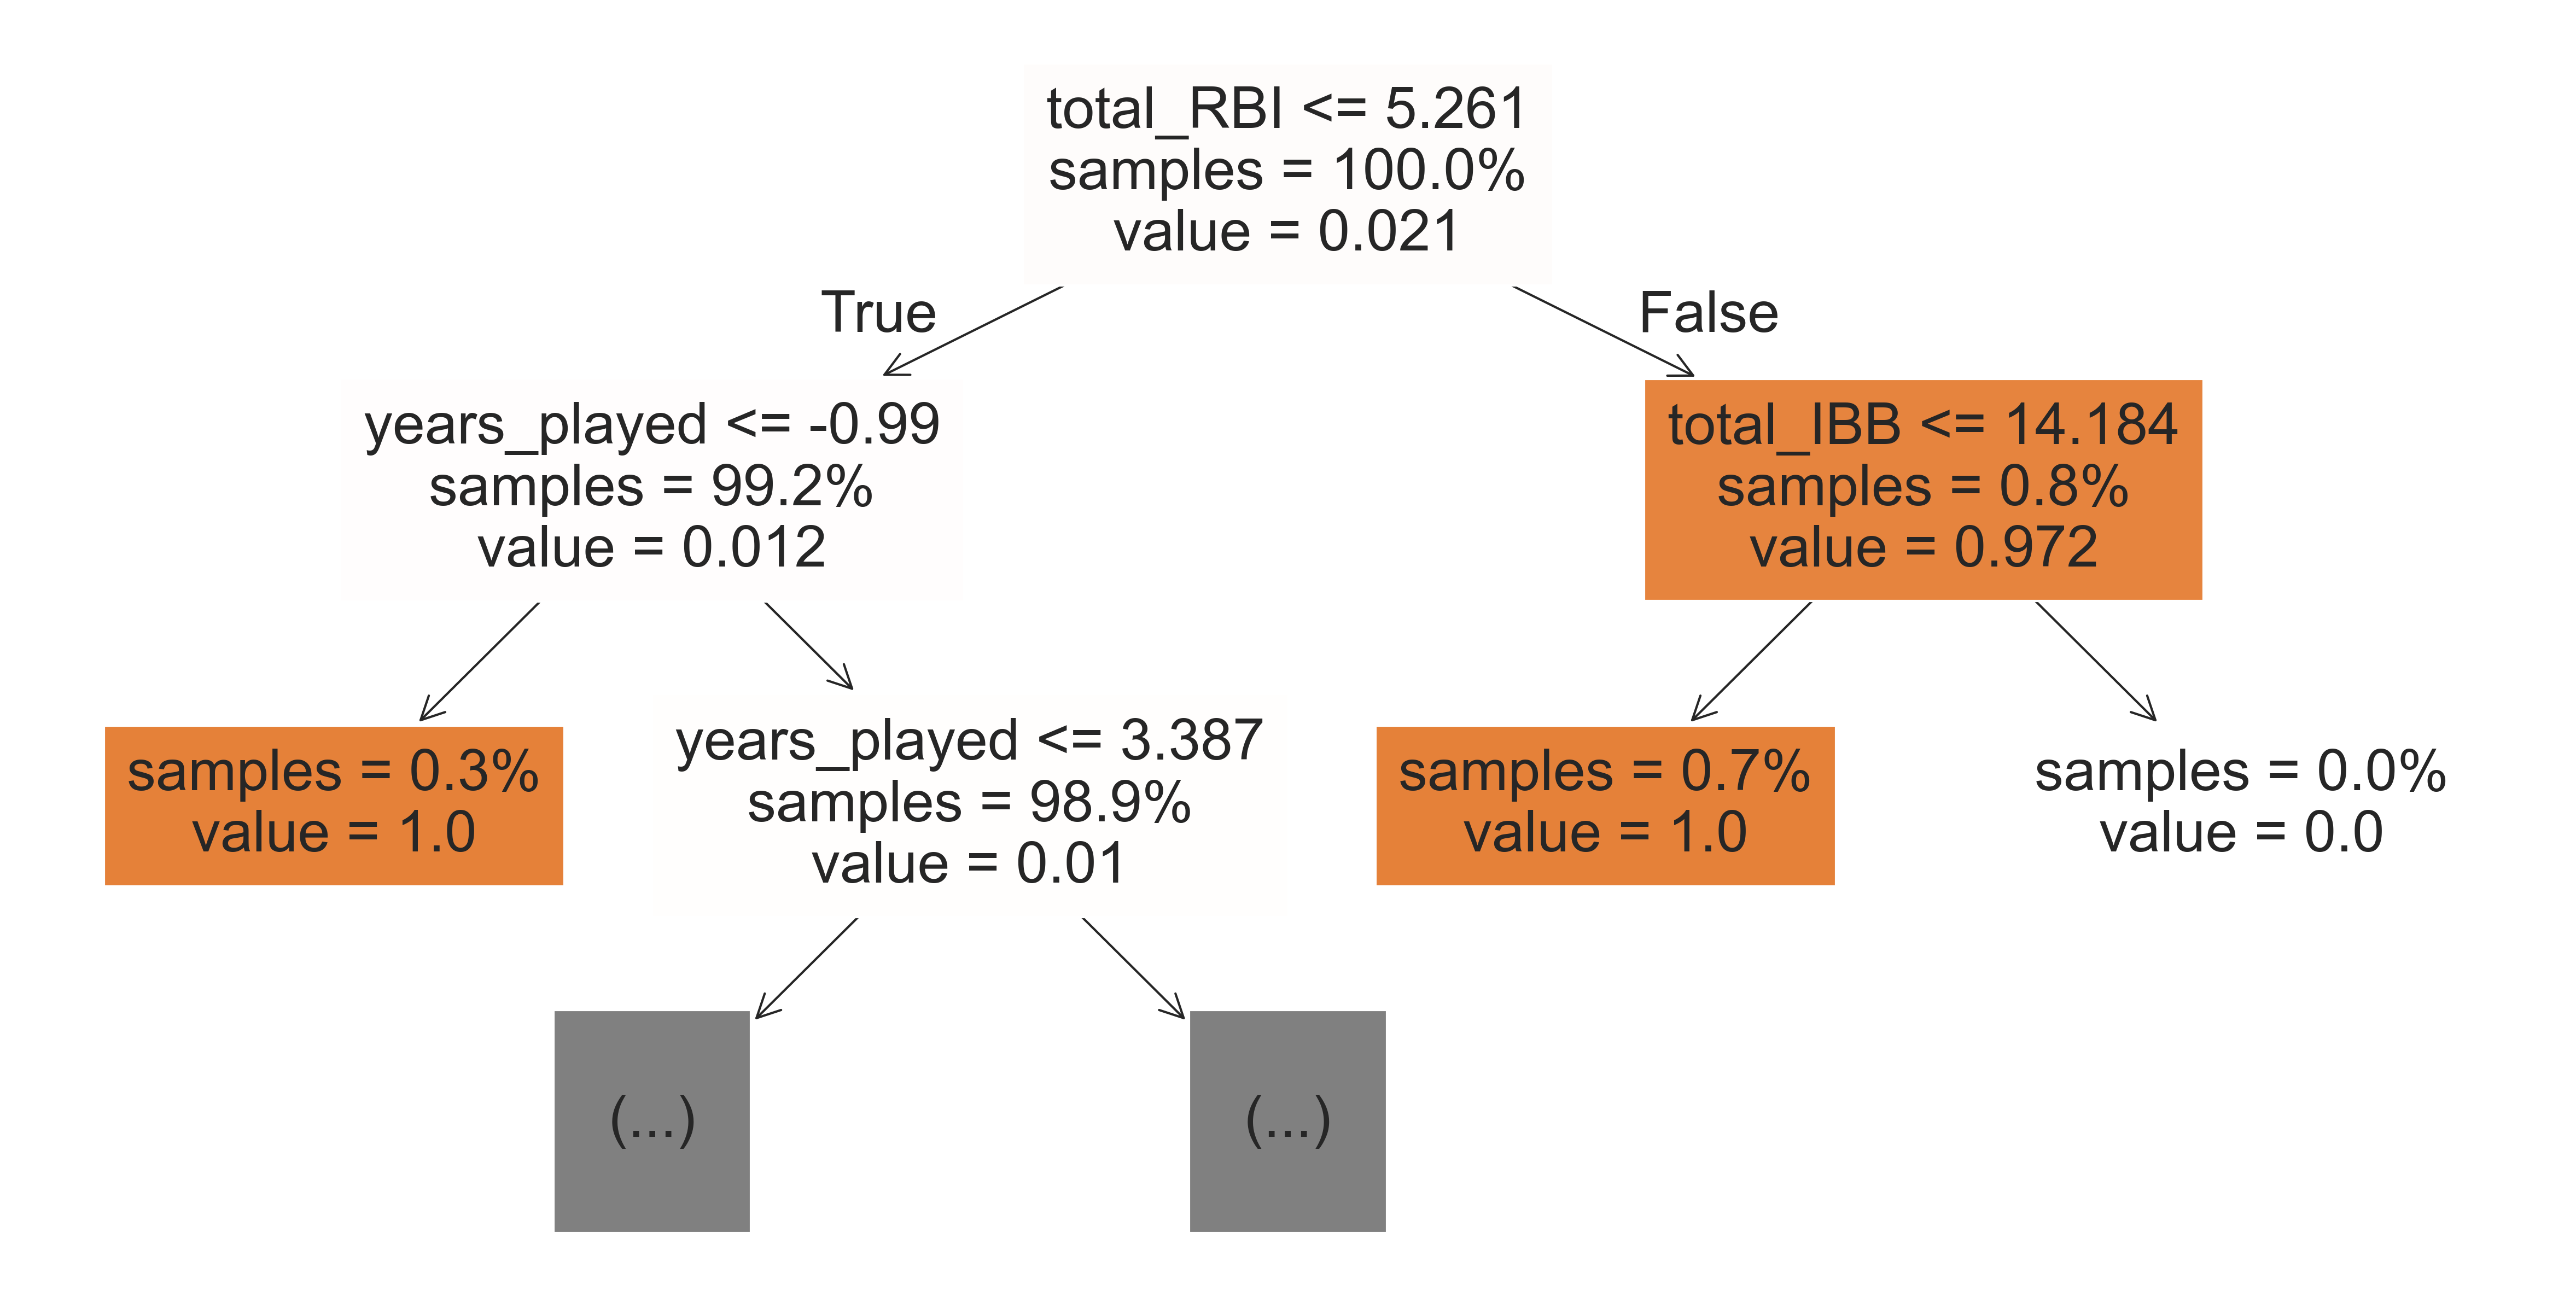

In [45]:
from sklearn.tree import plot_tree


# Visualize individual trees
for i in range(3):
    tree = rfr_model_1.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_columns, filled=True, max_depth=2, impurity=False, proportion=True)
    plt.show()


In [46]:
feature_importances = pd.Series(rfr_model_1.feature_importances_, X.columns)
top_rfr_features = feature_importances.nlargest(15)
print(top_rfr_features)

total_games      0.238618
total_runs       0.147167
years_played     0.140740
total_hits       0.065472
total_at_bats    0.055437
max_hits         0.055407
total_RBI        0.040151
total_SH         0.033328
OPS              0.031552
OBP              0.029788
total_singles    0.023119
SLG              0.021509
total_triples    0.020480
max_SB           0.017716
total_doubles    0.014172
dtype: float64



False Positives:


,playerID,years_played,total_games,total_at_bats,total_runs,total_hits,total_walks,total_doubles,total_triples,total_home_runs,total_RBI,total_SB,total_CS,total_BB,total_SO,total_IBB,total_HBP,total_SH,total_SF,total_GIDP,max_HR,max_hits,max_SB,total_singles,batting_avg,OBP,SLG,OPS
308,anderbr04,7,123.000000,65.000000,1.000000,6.000000,5.000000,3.000000,0.000000,0.000000,4.000000,0.000000,0.000000,5.000000,41.000000,0.000000,0.000000,10.000000,0.000000,2.000000,0.000000,4.000000,0.000000,3.000000,0.092308,0.157143,0.092308,0.249451
620,bakerch02,3,93.000000,146.000000,14.000000,27.000000,3.000000,2.000000,3.000000,0.000000,9.000000,0.000000,0.000000,3.000000,27.000000,0.000000,0.000000,9.000000,0.000000,4.000000,0.000000,12.000000,0.000000,22.000000,0.184932,0.201342,0.205479,0.406822
730,bardda01,5,211.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1448,blyzkmi01,2,70.000000,38.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,15.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.052632,0.076923,0.052632,0.129555
1839,brickra01,1,14.000000,8.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.250000,0.250000,0.250000,0.500000
2285,butersa01,9,359.000000,801.000000,63.000000,182.000000,86.000000,24.000000,3.000000,8.000000,76.000000,0.000000,0.000000,86.000000,85.000000,4.000000,3.000000,14.000000,7.000000,32.000000,3.000000,40.000000,0.000000,147.000000,0.227216,0.302142,0.250936,0.553078
3673,crowetr01,4,265.000000,818.000000,94.000000,196.000000,60.000000,41.000000,7.000000,4.000000,68.000000,35.000000,8.000000,60.000000,160.000000,1.000000,4.000000,9.000000,3.000000,24.000000,2.000000,111.000000,20.000000,144.000000,0.239609,0.291572,0.257946,0.549518
4016,daype01,4,46.000000,41.000000,1.000000,7.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,6.000000,0.170732,0.170732,0.170732,0.341463
4913,englije01,1,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4925,enyarte01,1,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



False Negatives:


,playerID,years_played,total_games,total_at_bats,total_runs,total_hits,total_walks,total_doubles,total_triples,total_home_runs,total_RBI,total_SB,total_CS,total_BB,total_SO,total_IBB,total_HBP,total_SH,total_SF,total_GIDP,max_HR,max_hits,max_SB,total_singles,batting_avg,OBP,SLG,OPS
105,adkinhe01,1,1.000000,5.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.400000,0.400000,0.400000,0.800000
194,allenfr01,6,181.000000,288.000000,23.000000,39.000000,35.000000,8.000000,6.000000,2.000000,25.000000,1.000000,0.000000,35.000000,126.000000,0.000000,1.000000,14.000000,0.000000,0.000000,1.000000,7.000000,1.000000,23.000000,0.135417,0.229102,0.170139,0.399241
223,allisdo01,10,318.000000,1407.000000,236.000000,381.000000,22.000000,43.000000,10.000000,2.000000,140.000000,5.000000,2.000000,22.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,90.000000,2.000000,326.000000,0.270789,0.282015,0.280739,0.562755
256,altizda01,6,514.000000,1734.000000,204.000000,433.000000,140.000000,36.000000,21.000000,4.000000,116.000000,119.000000,0.000000,140.000000,5.000000,0.000000,33.000000,84.000000,0.000000,0.000000,2.000000,145.000000,38.000000,372.000000,0.249712,0.305763,0.266436,0.572199
282,alvorbi01,5,265.000000,1069.000000,129.000000,270.000000,44.000000,31.000000,30.000000,3.000000,109.000000,27.000000,0.000000,44.000000,83.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,135.000000,21.000000,206.000000,0.252572,0.282120,0.286249,0.568369
445,arnovmo01,7,590.000000,2013.000000,234.000000,577.000000,185.000000,104.000000,12.000000,22.000000,261.000000,17.000000,0.000000,185.000000,139.000000,0.000000,10.000000,21.000000,0.000000,61.000000,10.000000,159.000000,7.000000,439.000000,0.286637,0.346679,0.314456,0.661135
797,baronst01,1,4.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1253,bevacku01,15,970.000000,2117.000000,214.000000,499.000000,221.000000,90.000000,11.000000,27.000000,275.000000,12.000000,20.000000,221.000000,329.000000,19.000000,5.000000,24.000000,31.000000,72.000000,6.000000,75.000000,3.000000,371.000000,0.235711,0.307956,0.266415,0.574370
2105,budd01,1,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2813,chapmar01,6,324.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


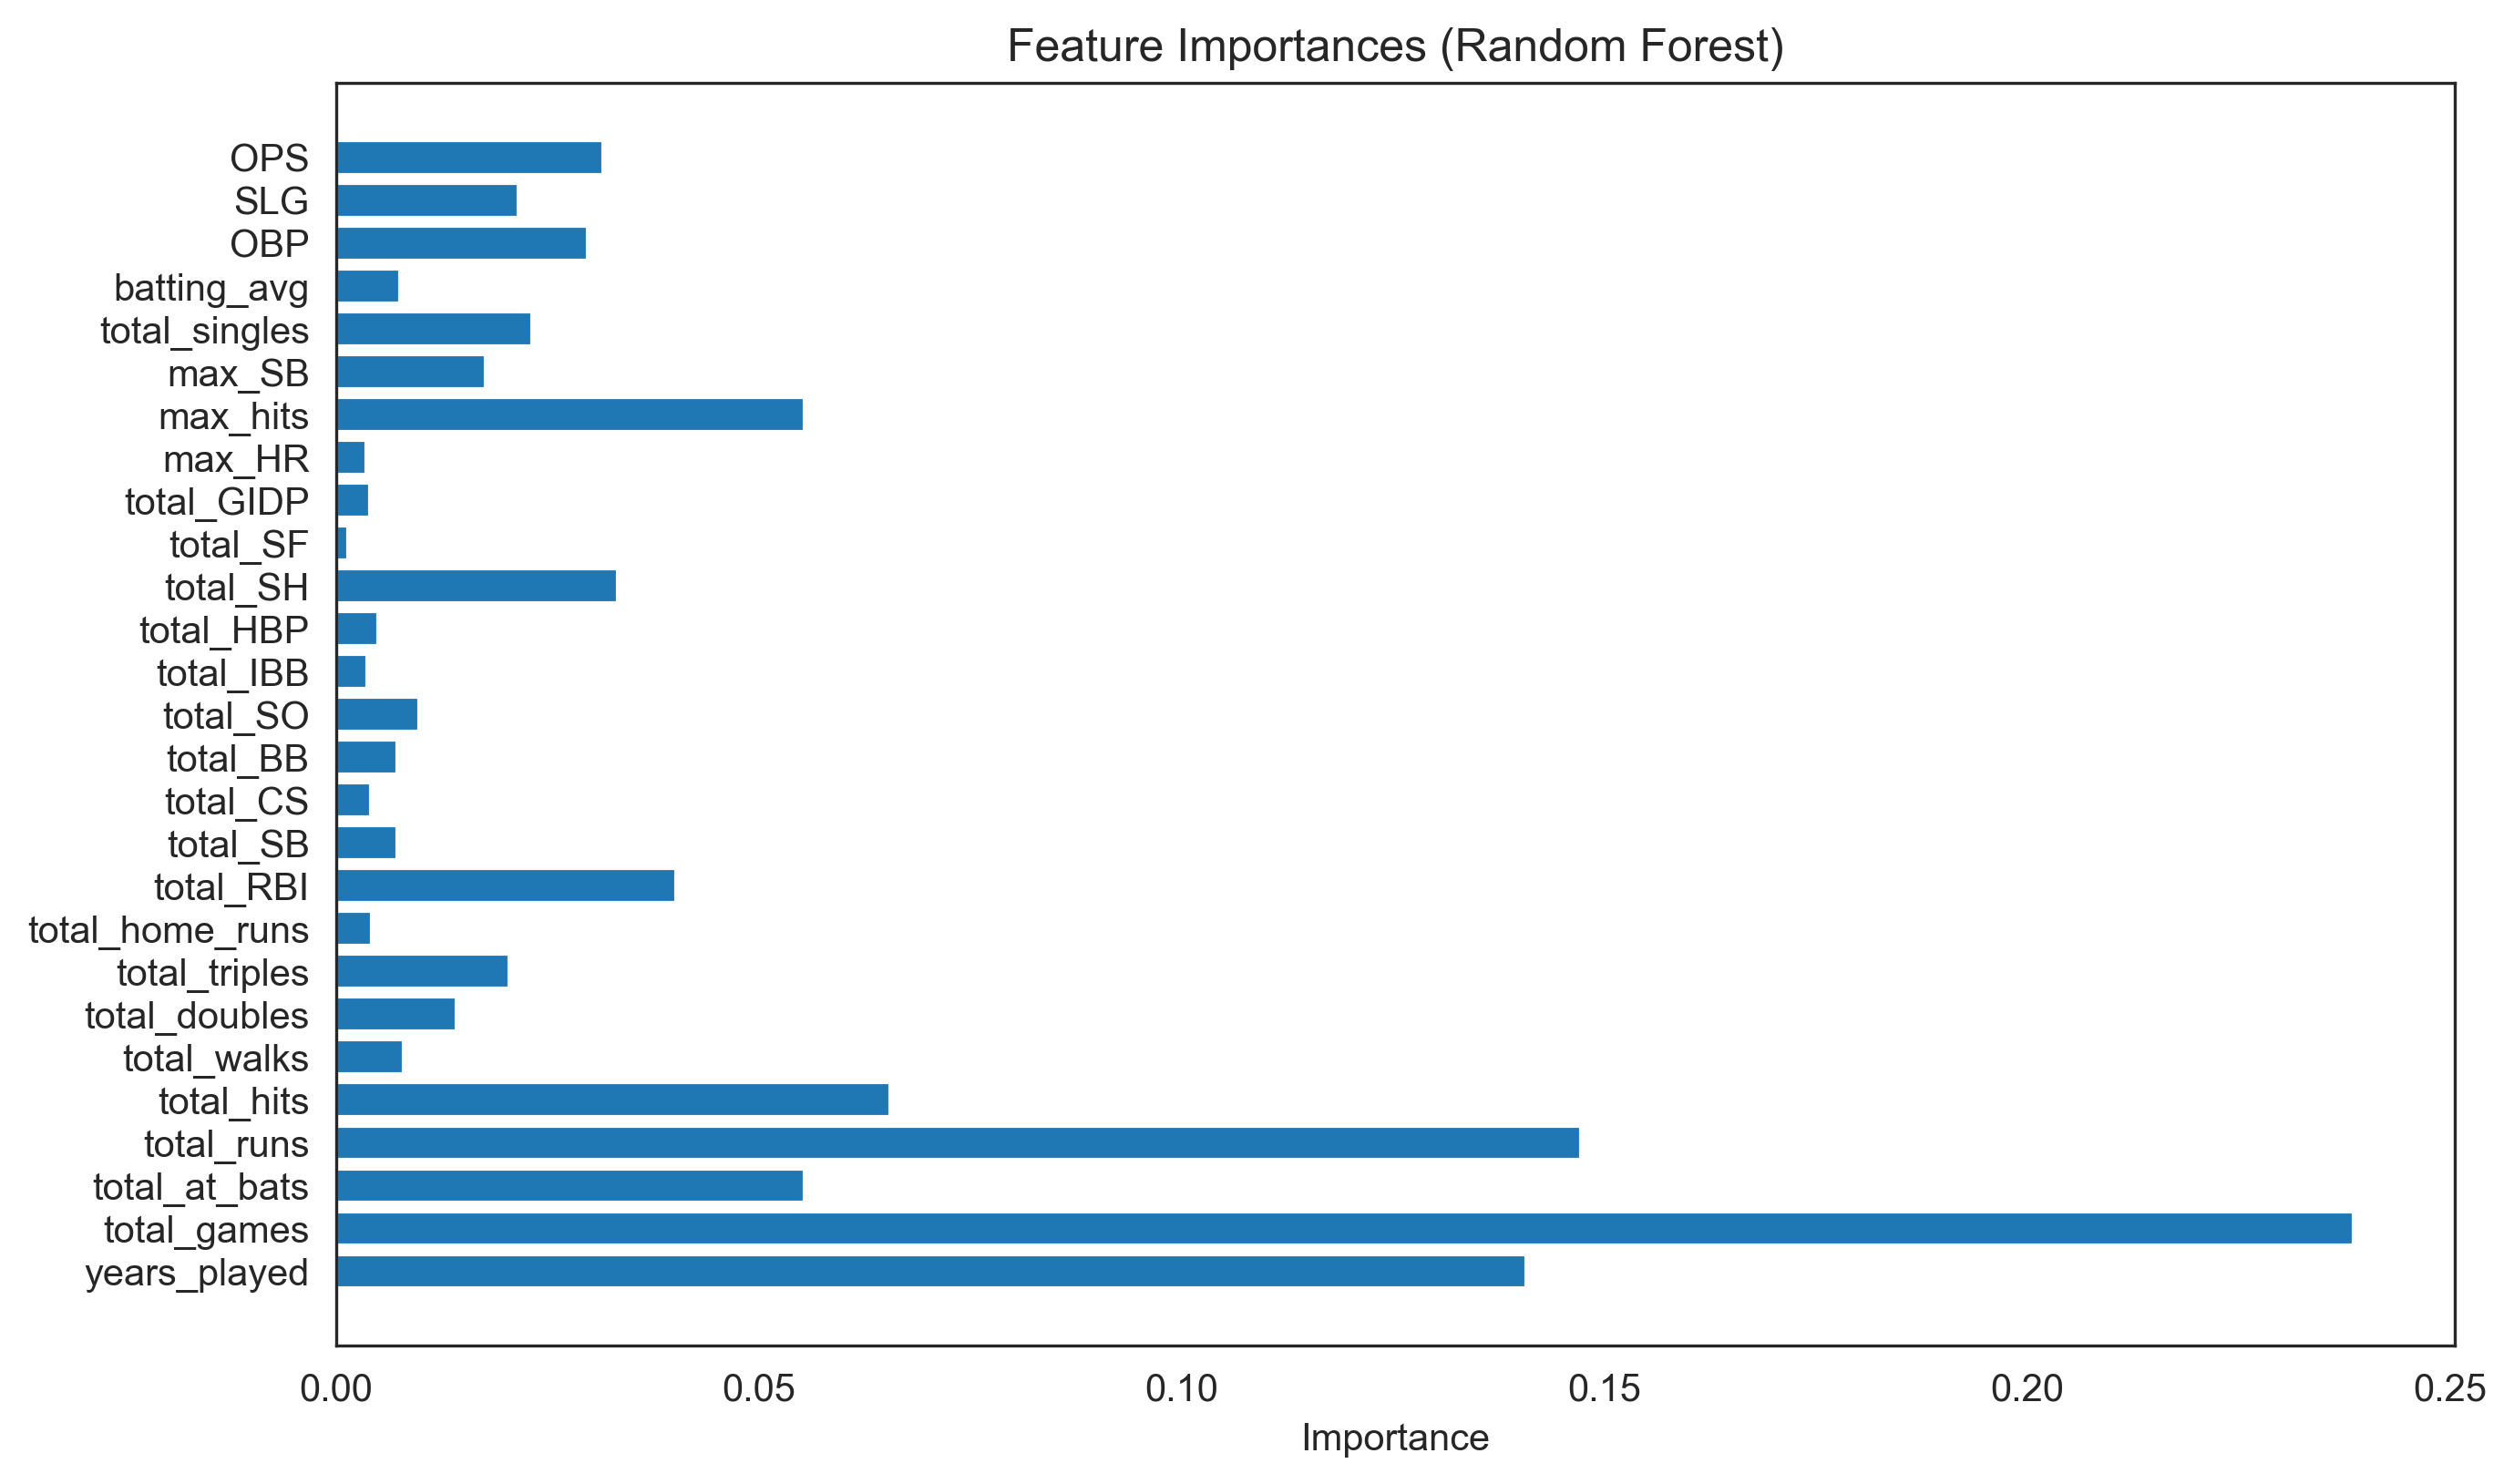

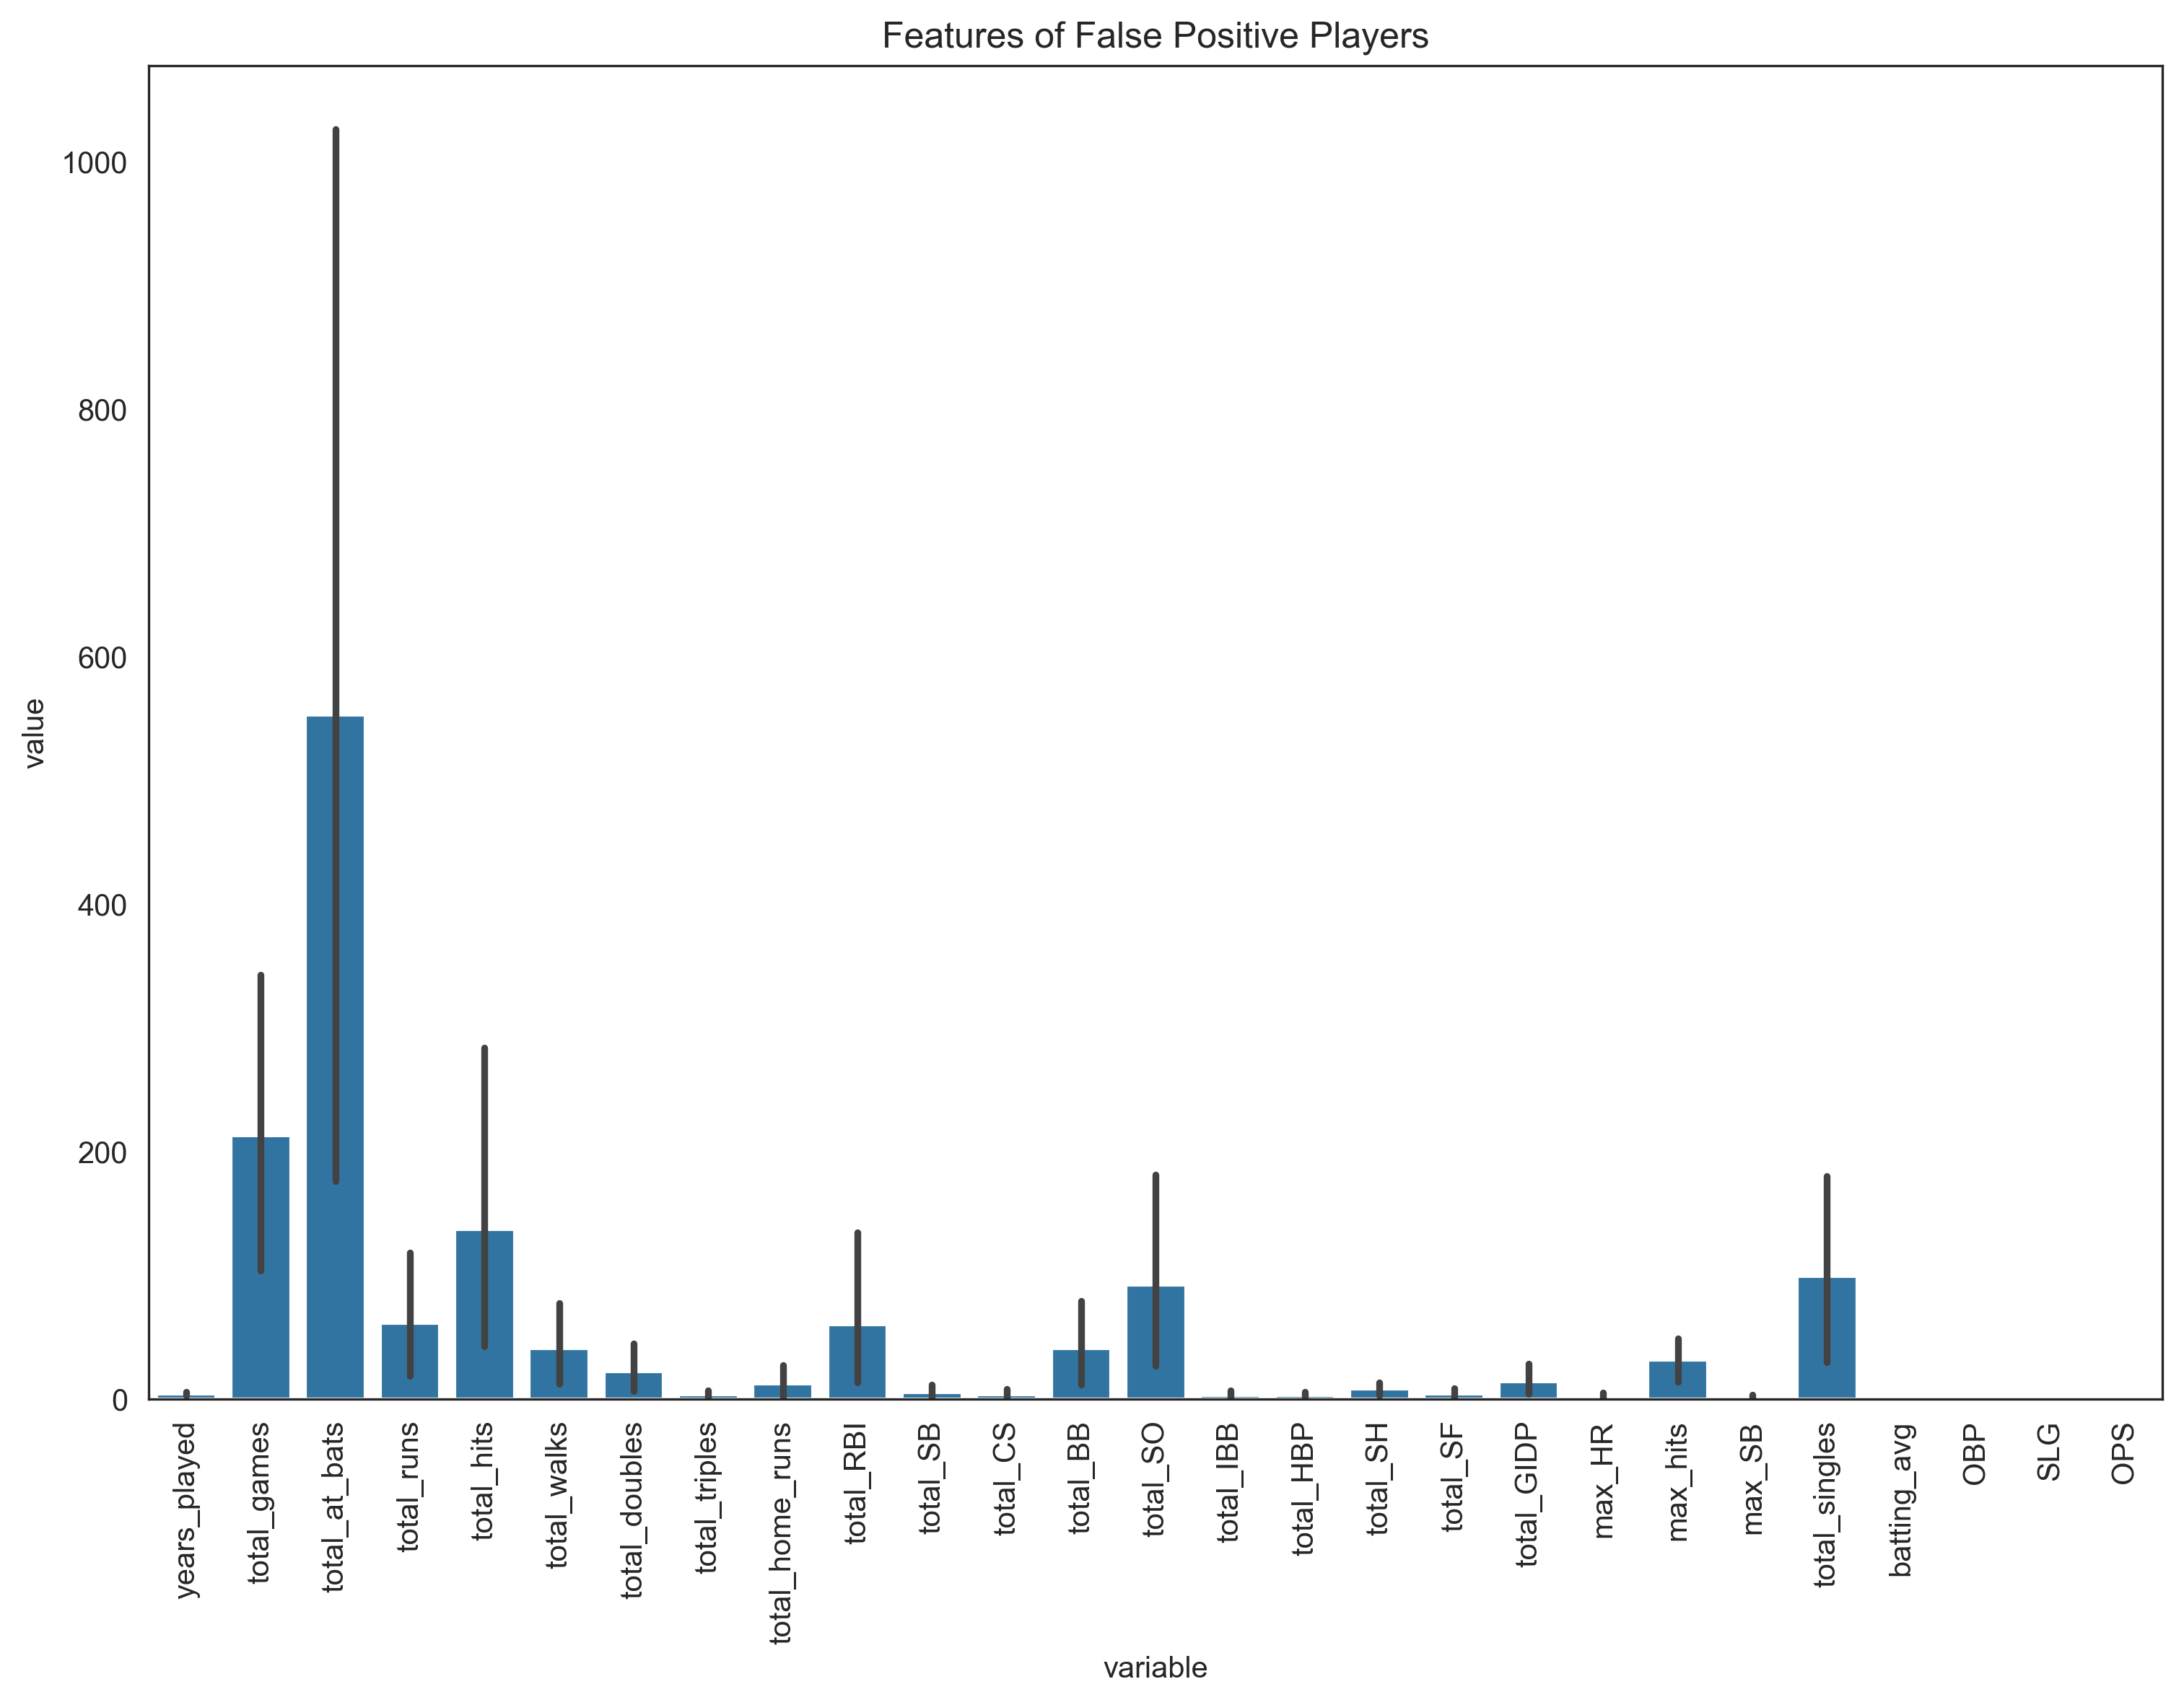

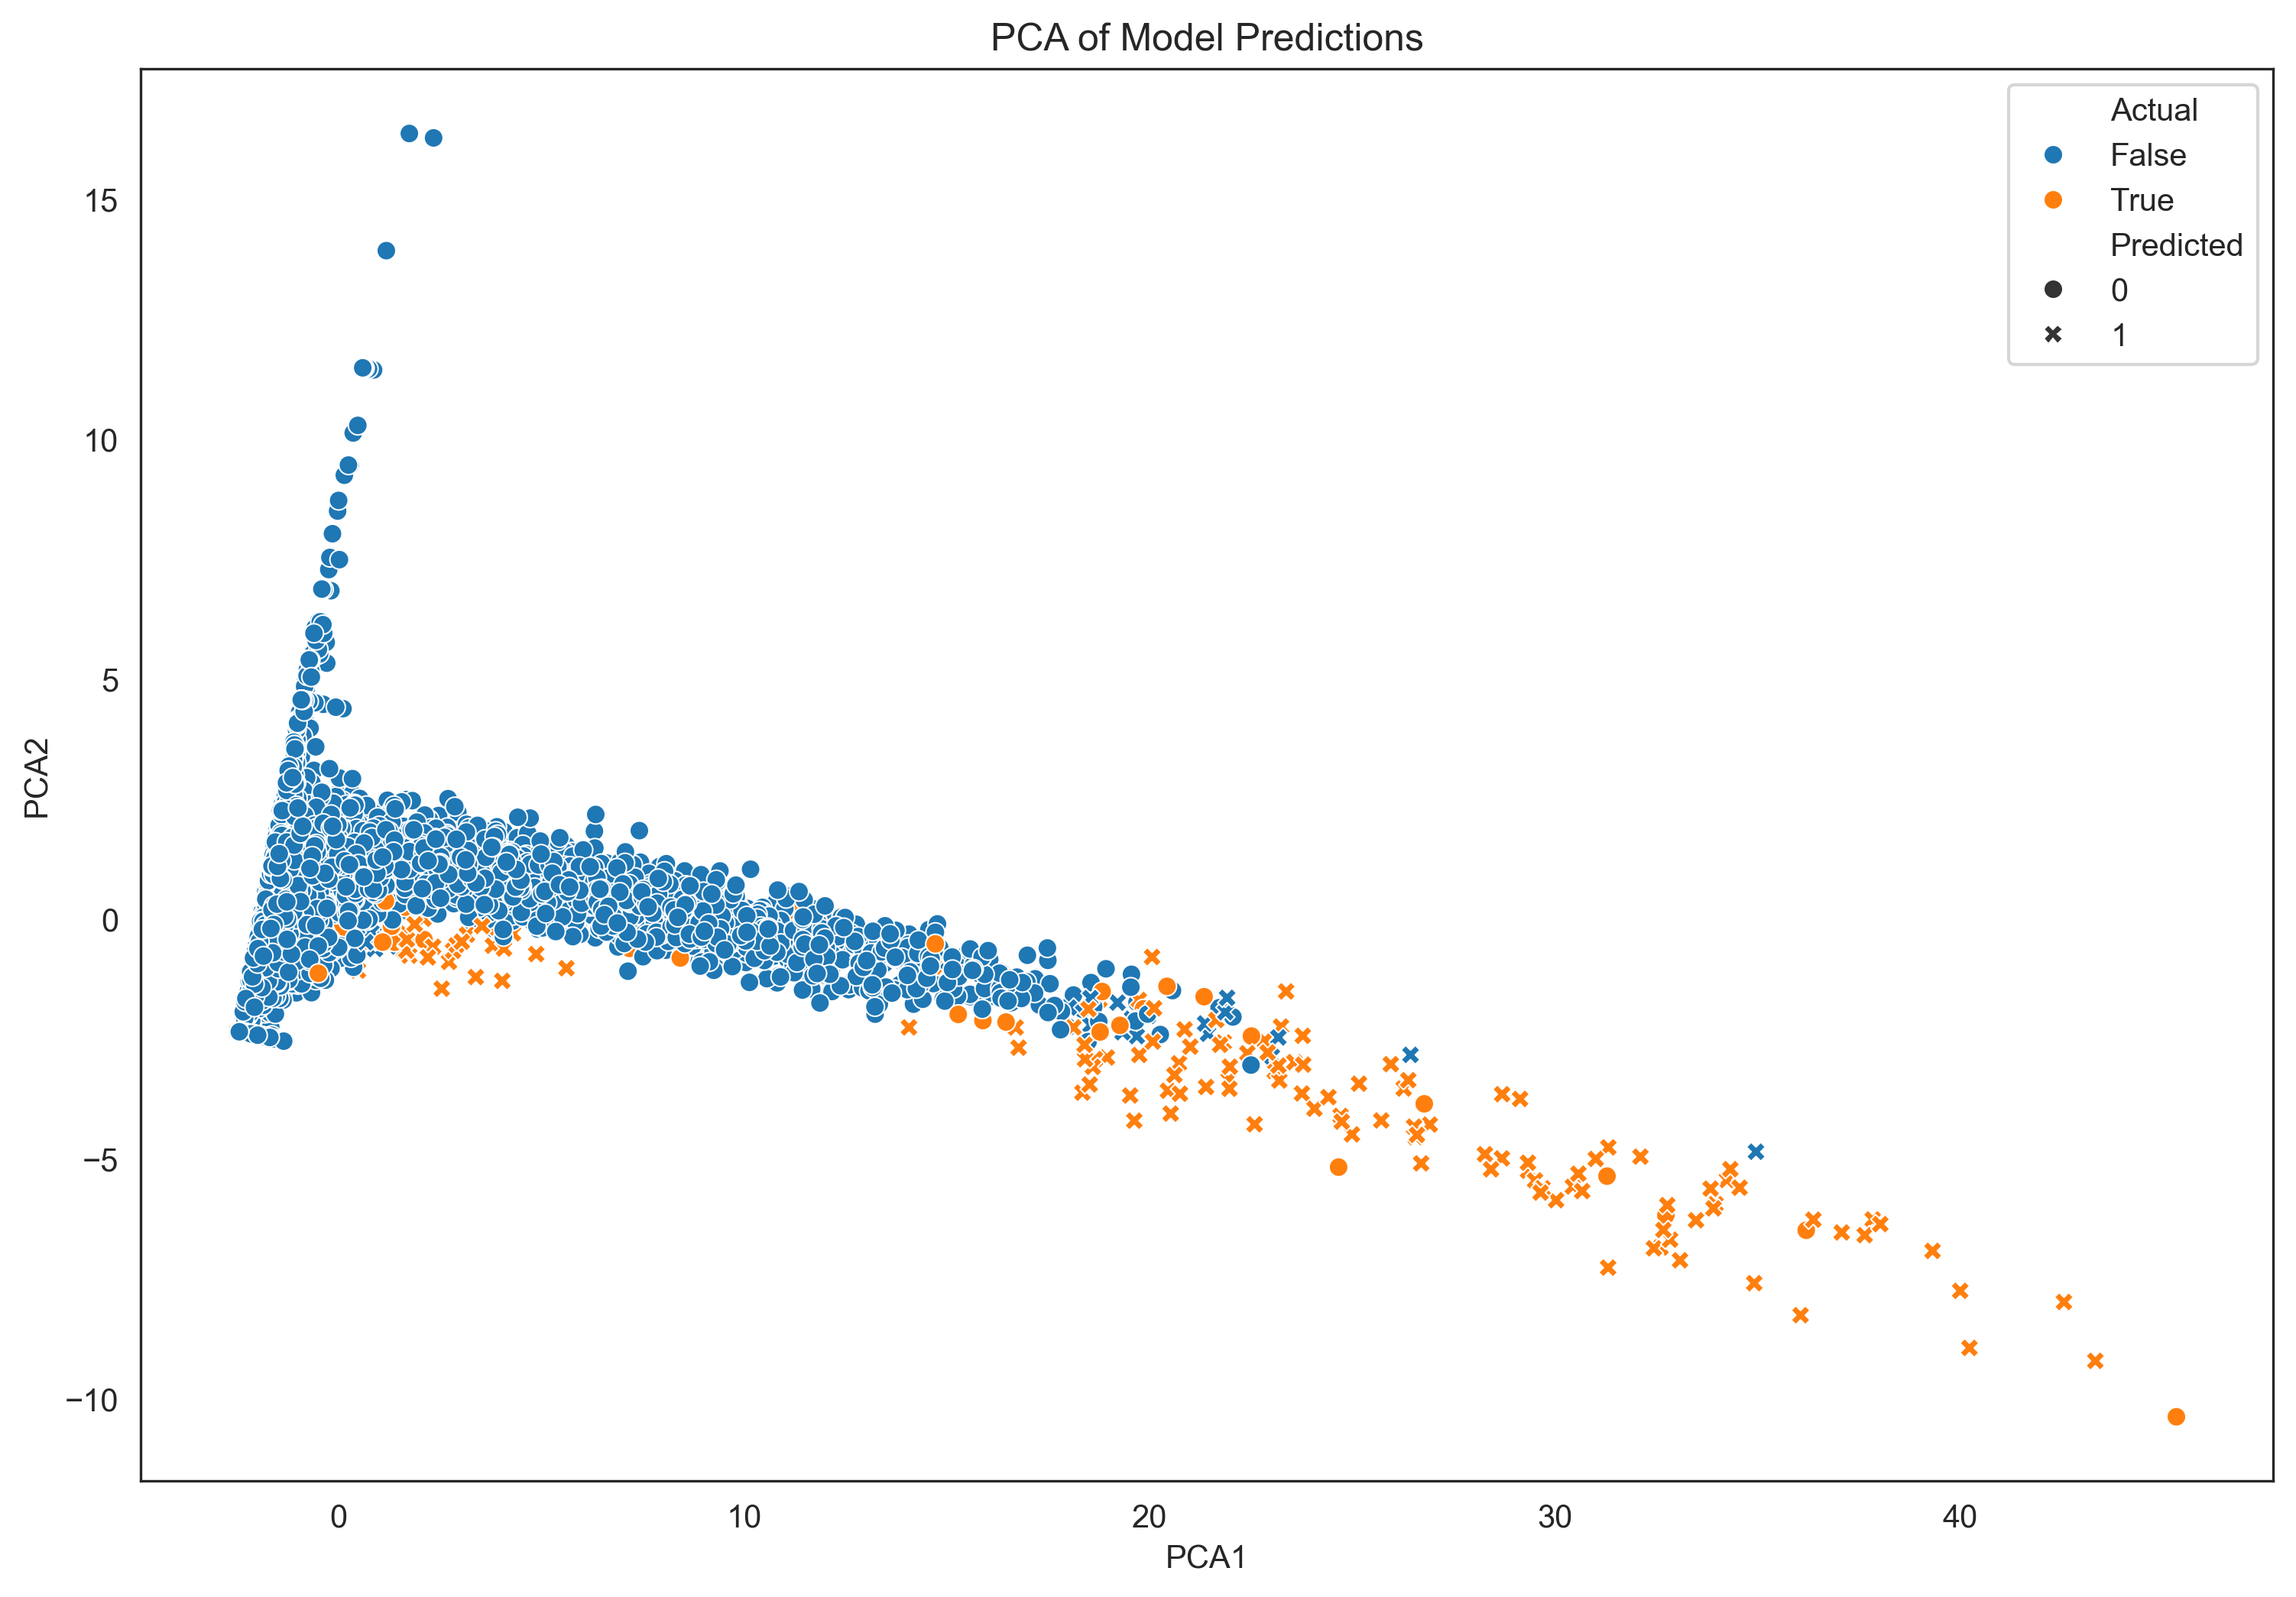

In [47]:
# Convert predictions to binary to analyze false positives and negatives
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_reset = y_test.reset_index(drop=True)

# Identify false positives and false negatives
false_positives = y_test_reset[(y_test_reset == 0) & (y_pred_binary == 1)].index
false_negatives = y_test_reset[(y_test_reset == 1) & (y_pred_binary == 0)].index

# Extract player details for false positives and false negatives
false_positive_players = eng_stats_df.loc[false_positives, ['playerID'] + feature_columns]
false_negative_players = eng_stats_df.loc[false_negatives, ['playerID'] + feature_columns]

print("\nFalse Positives:")
display(false_positive_players.style.set_table_attributes("style='display:inline'"))

print("\nFalse Negatives:")
display(false_negative_players.style.set_table_attributes("style='display:inline'"))
# Feature Importance Visualization
importances = rfr_model_1.feature_importances_
feature_names = feature_columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

# Player Data Comparison for False Positives
plt.figure(figsize=(12, 8))
false_positive_example = false_positive_players.melt(id_vars='playerID', value_vars=feature_columns)
sns.barplot(data=false_positive_example, x='variable', y='value')
plt.xticks(rotation=90)
plt.title("Features of False Positive Players")
plt.show()

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
visual_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Actual': y_test_reset,
    'Predicted': y_pred_binary
})
plt.figure(figsize=(12, 8))
sns.scatterplot(data=visual_df, x='PCA1', y='PCA2', hue='Actual', style='Predicted')
plt.title("PCA of Model Predictions")
plt.show()
